In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_curve
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import model_selection

from data_preprocess import pre_processing # Used to preprocess data
from sklearn.metrics import confusion_matrix

## Isolation Forest Accelerator for Anomaly Detection
The model takes in a dataframe and several other parameters and outs a series of whether a point is an anomaly or not

In [2]:
class IsolationForestAccel:
    def __init__(self, df, y_label, hypertune=False, isolation_params={}, 
                 sequence_matters=False, random_state=42, train_size=0.8,
                 **kwargs):
        """
        Isolation forest detects anomalies by randomly selecting a feature and then 
        randomly selecting a split value between the maximum and minimum values of 
        the selected features.
        
        params:
        df: dataframe which we want to detect the anomaly
        y_label: the y label of which we are predicting
        hypertune: whether or not we want to hypertune the model, if it is false
        then it will use base isolation forest params unless parameters are defined
        isolation_params: parameters if we do not want to hypertune the parameters, will 
        be used if hypertune is equal to True
        sequence_matters: True if it is a time series, False otherwise
        train_size: train size for train test split
        """      
        
        # If sequence is true then we will do a sequence split of first (n% and 1-n%)
        # The split is only used if we are hypertuning, other wise
        if sequence_matters == True:
            # Train test train split
            train_size = int(train_size * len(df))
            train, test = df[:train_size], df[train_size:]
        else: # We do a random split, usually for non time series data
            # test train split
            train, test = train_test_split(df, test_size=(1-train_size), random_state=random_state)
            
        # Drop labels here
        X_train = train.drop(y_label, axis=1)
        y_train = train[y_label].values
        X_test = test.drop(y_label, axis=1)
        y_test = test[y_label].values

        # Isolation Forest outputs 1 and -1 so we have this here to compare 
        y_test = [1 if x == 0 else -1 for x in y_test]
        y_train = [1 if x == 0 else -1 for x in y_train]
        
#         if len(isolation_params) == 0:
#             isolation_params = {'n_estimators': [10, 100, 200], 
#               'max_samples': [10, 100, 200], 
#               'contamination': [0.1, 0.3, 0.5], 
#               'max_features': [5, 10, 15], 
#               'bootstrap': [True, False], 
#               'n_jobs': [5, 10, 20]}

        if len(isolation_params) == 0:
            isolation_params = {'n_estimators': [100], 
              'max_samples': [100], 
              'contamination': [0.5, 1], 
              'max_features': [15], 
              'bootstrap': [True], 
              'n_jobs': [-1]}
        

        """
        If we want to hypertune we will use the train test split data to find the best
        model for the scoring metric we defined, we should always hypertune first, to find
        the best parameters, only set hypertune to false once we know the best parameters
        """
        if hypertune == True:
            
            # Some Grid Search params
            scoring = kwargs.get('scoring', 'f1')
            refit = kwargs.get('refit', True)
            cv = kwargs.get('cv', 10)
            return_train_score = kwargs.get('return_train_score', True)
            
            # For CV hypertuning
            skf = StratifiedKFold(n_splits=cv)
            folds = list(skf.split(X_train, y_train))
            
            isolation_forest = IsolationForest(random_state=random_state, behaviour='new')
            grid_dt_estimator = model_selection.GridSearchCV(isolation_forest, 
                                                 param_grid=isolation_params, 
                                                 scoring=scoring, 
                                                 refit=refit,
                                                 cv=folds,
                                                 return_train_score=return_train_score)
            
            grid_dt_estimator.fit(X_train, y_train)
            
            # Save the best model
            self.model = grid_dt_estimator.best_estimator_    
        else:
            n_estimators = kwargs.get('n_estimators', 100)
            max_samples = kwargs.get('max_samples', 100)
            contamination = kwargs.get('contamination', 0.5)
            max_features = kwargs.get('max_features', 15)
            bootstrap = kwargs.get('bootstrap', True)
            
            isolation_forest = IsolationForest(random_state=random_state, behaviour='new',
                                               n_estimators=n_estimators, max_samples=max_samples,
                                               contamination=contamination, max_features=max_features,
                                               bootstrap=bootstrap, n_jobs=-1)
            isolation_forest.fit(X_train)
            
            self.model = isolation_forest
            
    def predict(self, data):
        """
        This method predicts anomalies given a dataset that this class was trained on,
        the dataset must have the same columns as the trained model, it will output the 
        an array of anomalies (1 for anomaly or -1 for non-anomaly)
        """
        return self.model.predict(data)
    
    @staticmethod
    def get_scores(y_pred, y_true, scoring='f1', y_proba=None):
        if scoring.startswith('roc'):
            if  y_proba is None:
                return 'ROC AUC requires probability scores'
            else:
                return roc_auc_score(y_pred, y_proba)
            
        # Convert scores for isolation Tree for Non-ROCAUC
        y_pred = [0 if x== 1 else 1 for x in y_pred]
        y_true = [0 if x== 1 else 1 for x in y_true]
        
        if scoring.startswith('f1'):
            score = f1_score(y_pred, y_true)
        elif scoring.startswith('pre'):
            score = precision_score(y_pred, y_true)
        elif scoring.startswith('rec'):
            score = recall_score(y_pred, y_true)
        elif scoring.startswith('acc'):
            score = accuracy_score(y_pred, y_true)
        else:
            score = f"Scoring Method: {scoring} not implemented"
        return score
    
    @staticmethod
    def get_all_scores(y_pred, y_true, y_proba):
        # This just prints all scores above above
        print(f"ROC_AUC: {IsolationForestAccel.get_scores(y_pred, y_true, scoring='roc', y_proba=y_proba):0.2f}")
        print(f"F1: {IsolationForestAccel.get_scores(y_pred, y_true, scoring='f1'):0.2f}")
        print(f"Precision: {IsolationForestAccel.get_scores(y_pred, y_true, scoring='pre'):0.2f}")
        print(f"Recall: {IsolationForestAccel.get_scores(y_pred, y_true, scoring='rec'):0.2f}")
        print(f"Accuracy: {IsolationForestAccel.get_scores(y_pred, y_true, scoring='acc'):0.2f}")

    @staticmethod
    def get_confusion_matrix(y_pred, y_true, cmap='coolwarm'):
        plt.figure(figsize=(10,8))
        
        cf_matrix = confusion_matrix(y_test, y_true)
        group_names = ['True Anomalies', 'Unflagged Anom', 'Falsely Flagged Anom', 'Non-Anomalies']
        group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
        
        # Labels combine group names, counts, and percentages
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)] 
        labels = np.asarray(labels).reshape(2,2)
              
        sns.heatmap(cf_matrix, annot=labels, fmt="", cmap=cmap)

##### Preprocess the Data

In [3]:
df = pre_processing(pd.read_csv("data.csv"))

##### Set aside some data that the model doesn't see so that we can calculate how well the model does

In [4]:
# We will set aside 20% of the data
train_size = 0.8
y_label = 'default_ind'

# Split data 
train_size = int(train_size * len(df))
train, test = df[:train_size], df[train_size:]

# Test is for testing purposes later
X_test = test.drop(y_label, axis=1)
y_test = test[y_label].values
y_test = [1 if x == 0 else -1 for x in y_test]

##### Model 

In [5]:
"""
Hypertuning takes a while to run 
feel free to set hypertune to True to test it out
it will take over an hour depending on machine
"""

iso_forest = IsolationForestAccel(df=df, y_label=y_label, hypertune=True)

C:\Users\Himanshu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Himanshu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Himanshu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Himanshu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Himanshu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:

##### Confusion Matrix

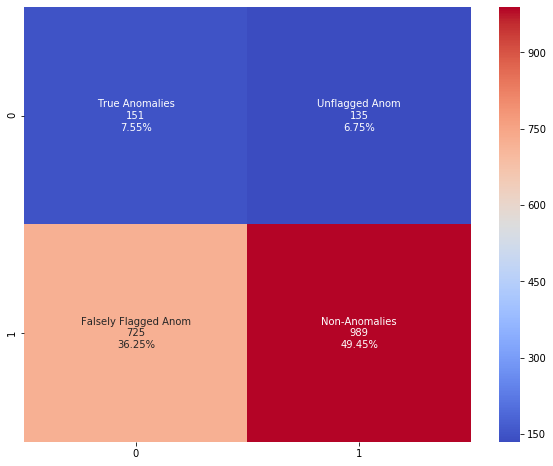

In [6]:
y_pred = iso_forest.predict(X_test)
y_proba = iso_forest.model.decision_function(X_test) # For ROC score
iso_forest.get_confusion_matrix(y_test, y_pred)

##### Scores

In [7]:
iso_forest.get_all_scores(y_test, y_pred, y_proba=y_proba)

ROC_AUC: 0.56
F1: 0.26
Precision: 0.17
Recall: 0.53
Accuracy: 0.57


In [11]:
cf = np.array([[151,135],
[500,900]])

In [12]:
cf

array([[151, 135],
       [500, 900]])

array([[900, 500],
       [135, 151]])